In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
notebook = "real4_Concrete"

In [5]:
from ucimlrepo import fetch_ucirepo

import numpy as np

# fetch dataset
concrete = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete.data.features
y = concrete.data.targets

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
ndpost = 10000
nskip = 0
n_trees = 100

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
proposal_probs_default = {
    'grow': 0.25,
    'prune': 0.25,
    'change': 0.4,
    'swap': 0.1
}
bart = DefaultBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_default, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_default.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_default.npy', np.array(rmses))

Iterations: 100%|██████████| 10000/10000 [01:25<00:00, 117.28it/s]


In [10]:
proposal_probs_mtmh = {
    'multi_grow': 0.25,
    'multi_prune': 0.25,
    'multi_change': 0.4,
    'multi_swap': 0.1
}
bart = MultiBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_mtmh, multi_tries=10, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_mtmh.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_mtmh.npy', np.array(rmses))

Iterations: 100%|██████████| 10000/10000 [08:48<00:00, 18.91it/s]


In [11]:
from diagnosis import segmented_ljung_box_test, segment_ess_efficiency

## Default

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


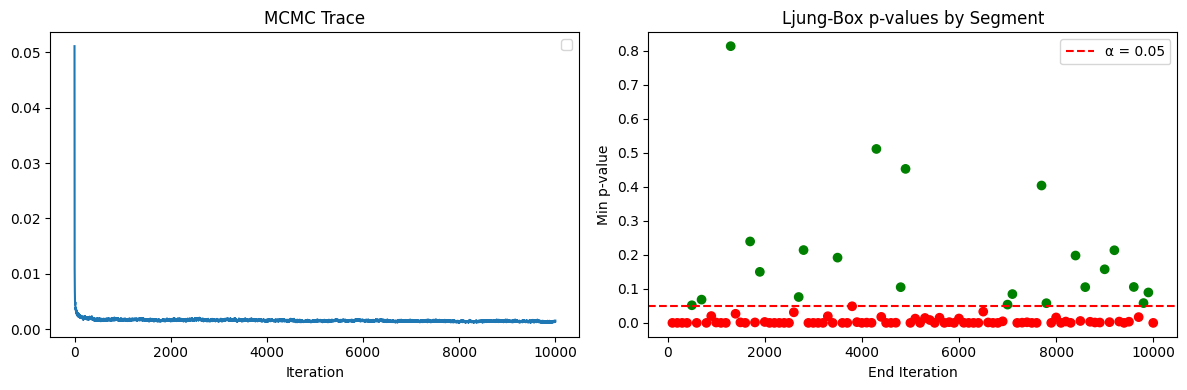

Chain converged: False
Convergence rate: 22.00%


In [12]:
# Diagnose default sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

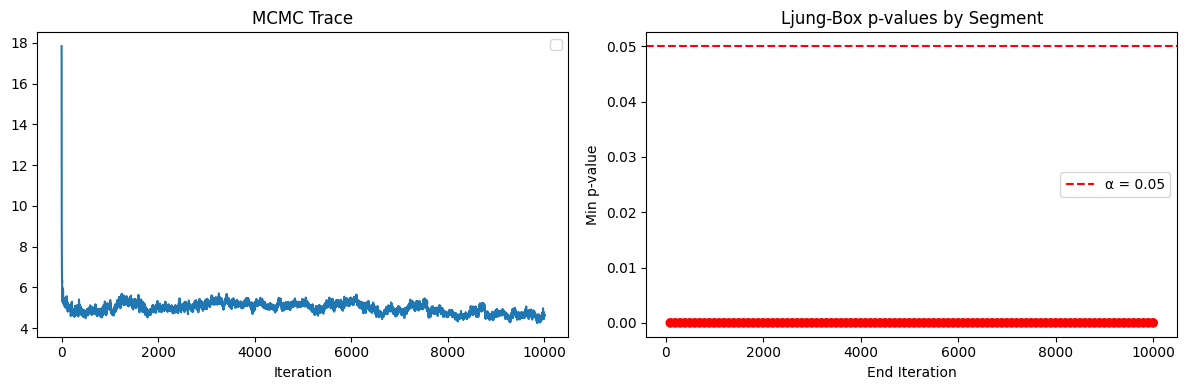

Chain converged: False
Convergence rate: 0.00%


In [13]:
# Diagnose default rmse convergence
rmses = np.load(f'store/{notebook}_rmses_default.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

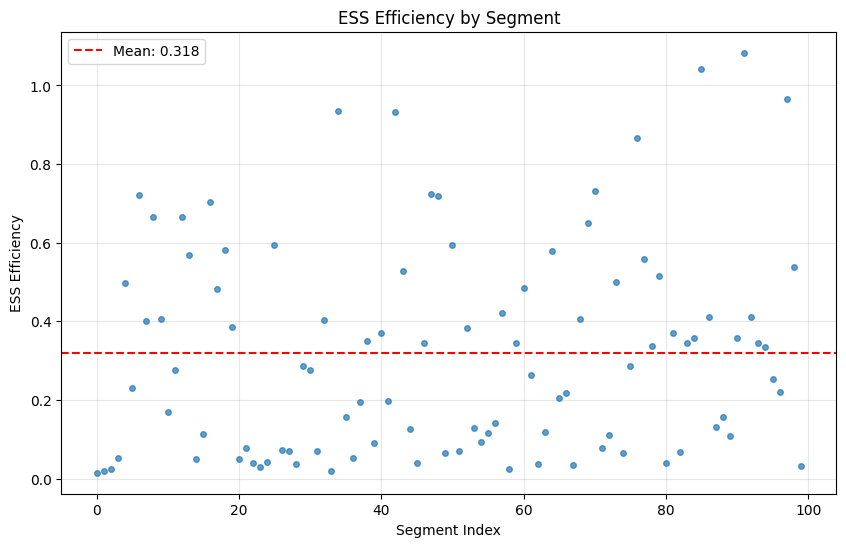

In [14]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

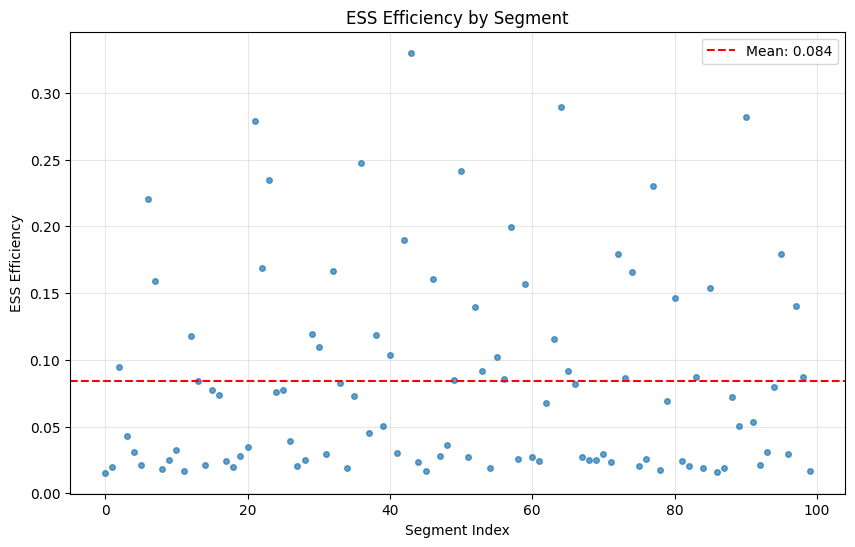

In [15]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

In [9]:
from diagnosis import plot_autocorrelation

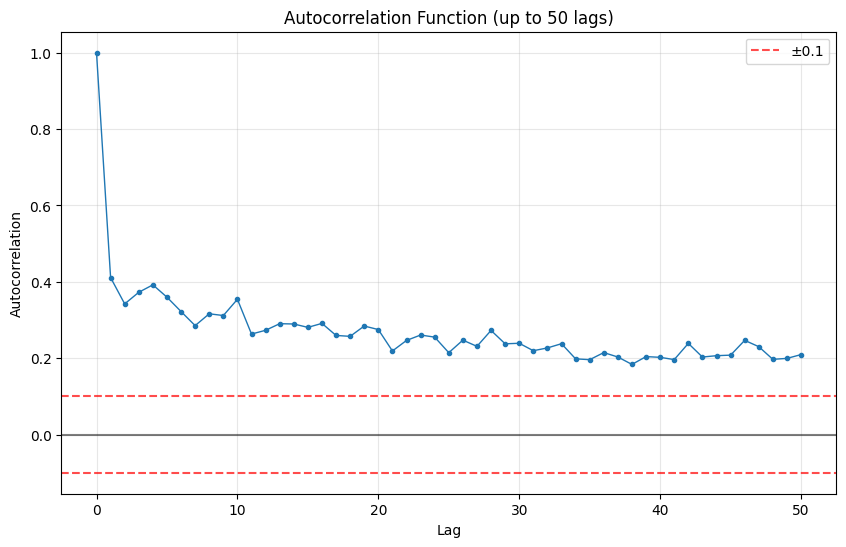

array([1.        , 0.41112781, 0.34214073, 0.37259824, 0.39207213,
       0.35976057, 0.32218828, 0.28526507, 0.31627075, 0.31165846,
       0.35419853, 0.26321194, 0.27302663, 0.29034448, 0.28951988,
       0.28067282, 0.29111081, 0.25954069, 0.25715306, 0.28420777,
       0.2749464 , 0.21887027, 0.24644113, 0.26063534, 0.25511485,
       0.21437809, 0.24724662, 0.23096435, 0.27272158, 0.23762717,
       0.23904155, 0.21955933, 0.22683413, 0.23792561, 0.19825368,
       0.19607303, 0.21464149, 0.20304304, 0.1836929 , 0.20413522,
       0.20222298, 0.19627591, 0.2387023 , 0.20300038, 0.20652659,
       0.2079362 , 0.24668014, 0.23009669, 0.19695661, 0.19944737,
       0.20937951])

In [10]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

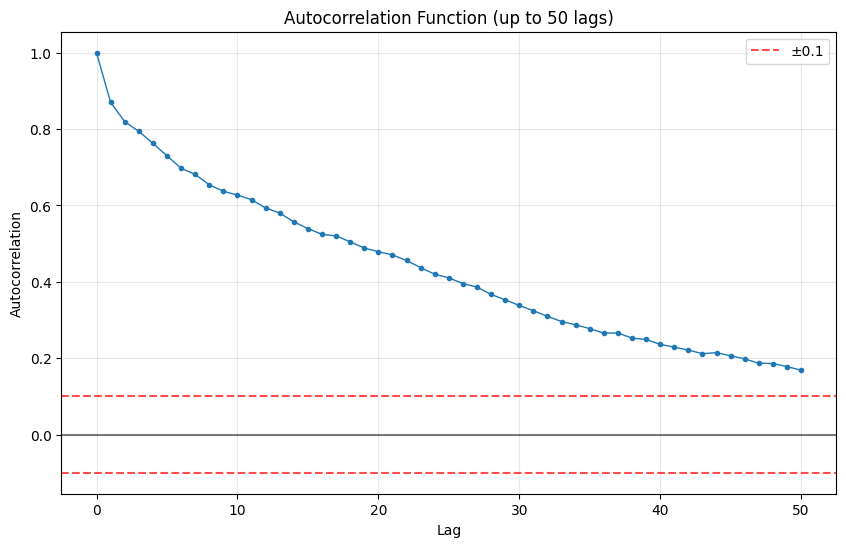

array([1.        , 0.87023913, 0.81954339, 0.79409586, 0.76286612,
       0.72993477, 0.69750811, 0.68135335, 0.65423738, 0.63715323,
       0.62711715, 0.61511784, 0.59350229, 0.58015594, 0.55711517,
       0.5395269 , 0.52424286, 0.52039398, 0.50471916, 0.48867271,
       0.47885226, 0.470518  , 0.45592555, 0.43717162, 0.42005757,
       0.41050454, 0.39539146, 0.38616237, 0.36713477, 0.35270857,
       0.33808081, 0.32439218, 0.30961326, 0.29605109, 0.28742269,
       0.27740617, 0.26554862, 0.26600905, 0.25263585, 0.24896126,
       0.23640808, 0.22879848, 0.22134874, 0.21162118, 0.21459474,
       0.20619591, 0.1980886 , 0.18682885, 0.18597732, 0.17798929,
       0.16856119])

In [11]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)

## MTMH

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


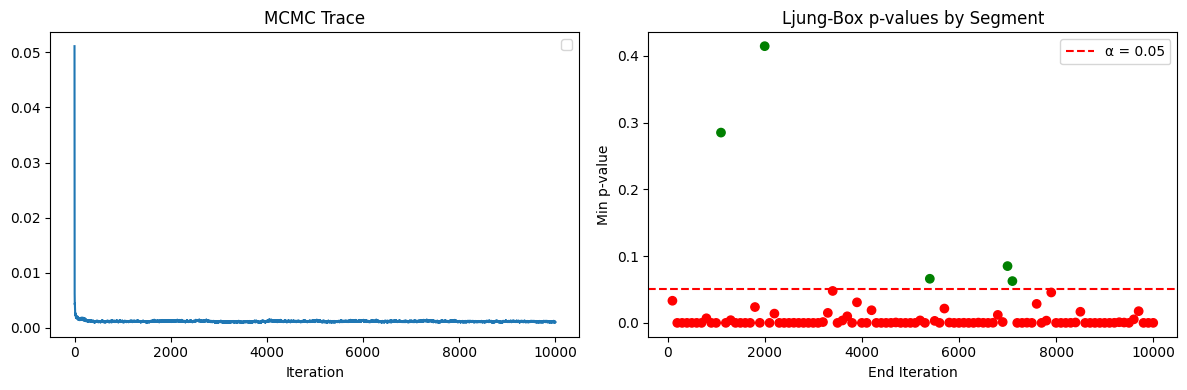

Chain converged: False
Convergence rate: 5.00%


In [16]:
# Diagnose mtmh sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

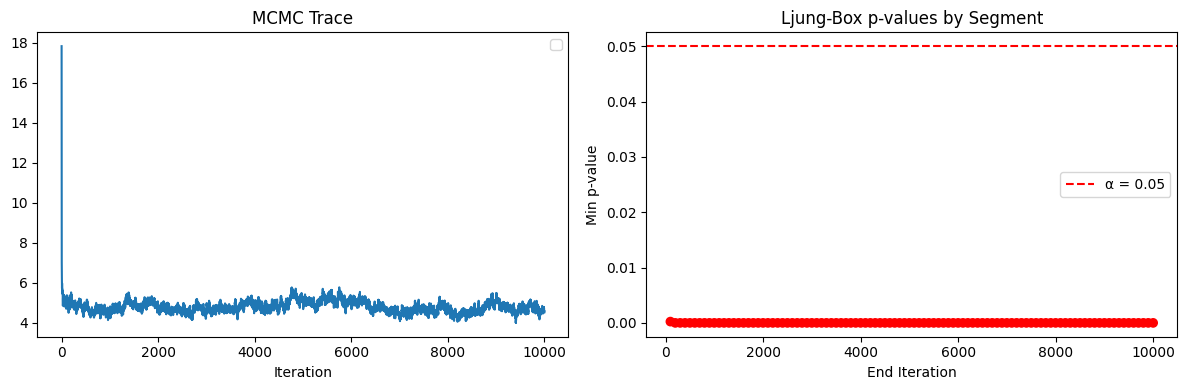

Chain converged: False
Convergence rate: 0.00%


In [17]:
# Diagnose mtmh rmse convergence
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

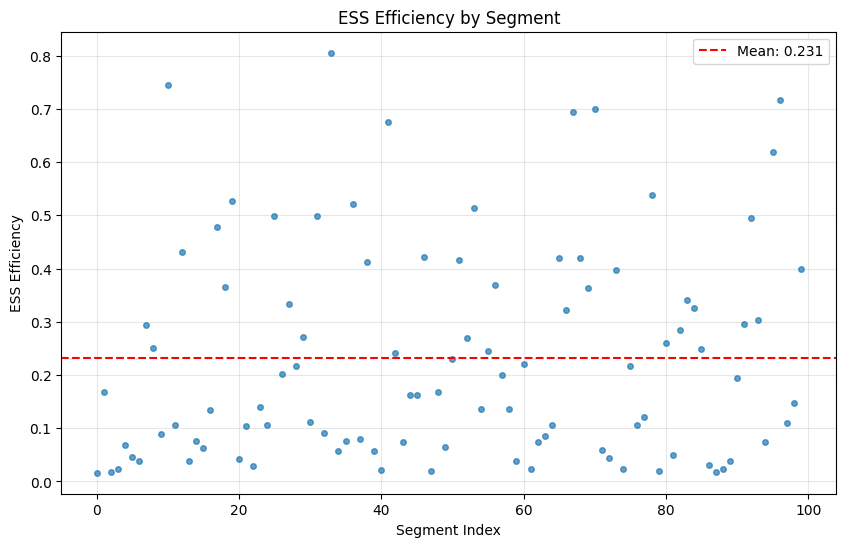

In [18]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

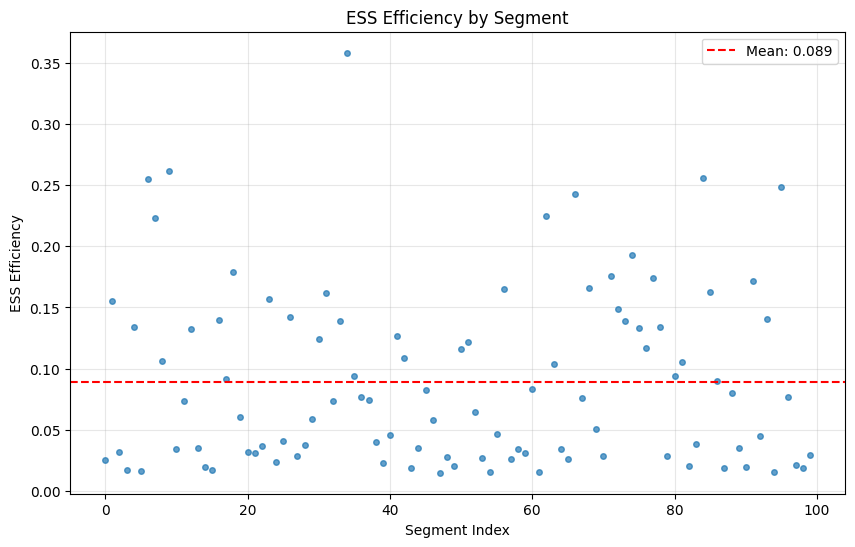

In [19]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

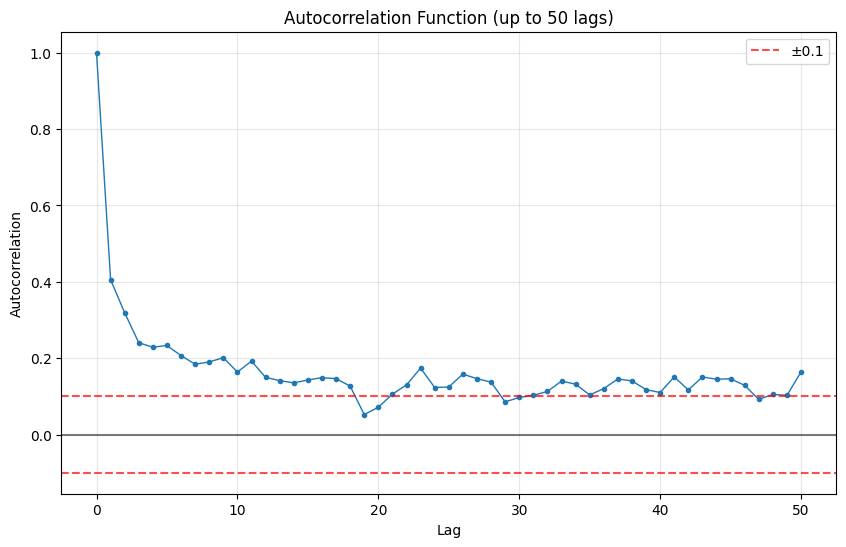

array([1.        , 0.40552634, 0.318861  , 0.24045259, 0.2287533 ,
       0.23322068, 0.20663231, 0.18427121, 0.19003386, 0.20142894,
       0.16361021, 0.19234768, 0.14972533, 0.14119547, 0.13538188,
       0.14294908, 0.1489018 , 0.14649482, 0.12678969, 0.05229982,
       0.07148746, 0.10575291, 0.13006813, 0.17388846, 0.12319892,
       0.12457451, 0.15829679, 0.14628547, 0.1372202 , 0.08554023,
       0.09713254, 0.10267829, 0.11297148, 0.13994446, 0.13192883,
       0.10367608, 0.1202952 , 0.14558748, 0.14047047, 0.11764941,
       0.11010277, 0.15099484, 0.11672597, 0.15087299, 0.14482859,
       0.14602617, 0.12875163, 0.09207099, 0.10507697, 0.10272111,
       0.16394374])

In [12]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

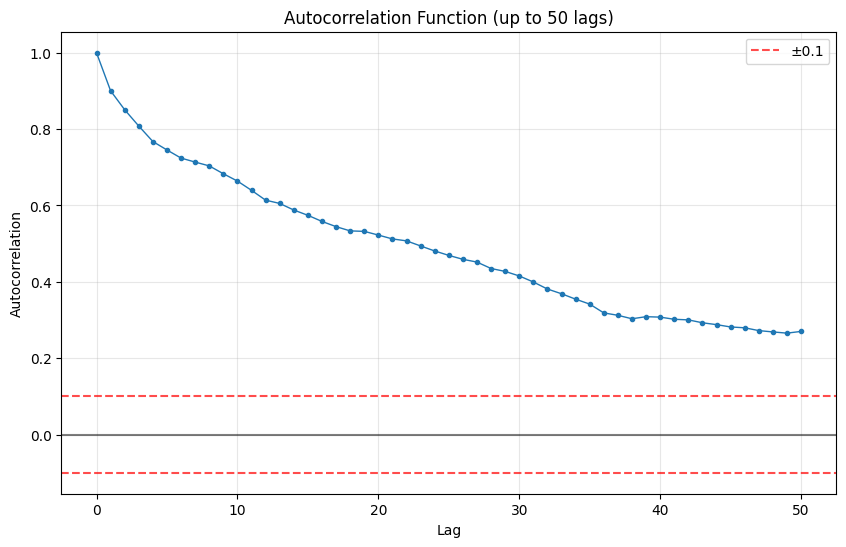

array([1.        , 0.90029055, 0.85060606, 0.80795776, 0.76739307,
       0.74533738, 0.72402492, 0.71360873, 0.70360848, 0.68308857,
       0.66387704, 0.63959336, 0.61386375, 0.60529277, 0.58800954,
       0.57420419, 0.55816772, 0.54451681, 0.53335901, 0.53212698,
       0.5224466 , 0.51231601, 0.50727034, 0.49391468, 0.48078429,
       0.46918492, 0.4589657 , 0.45167784, 0.43486359, 0.42725472,
       0.41533943, 0.39954292, 0.38112052, 0.36872675, 0.35459404,
       0.34161606, 0.3185736 , 0.31229294, 0.30321085, 0.30866057,
       0.30752298, 0.30187484, 0.30029732, 0.29272765, 0.28786464,
       0.28174102, 0.27958541, 0.27222303, 0.26873303, 0.26556703,
       0.27008685])

In [13]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)